# GNN
---
01.GraphNN con Pytorch

Nuestra primera red - Prueba GraphSageConv sobre Cora

---
Jonnatan Arias Garcia

jariasg@uniquindio.edu.co

jonnatan.arias@utp.edu.co

Trabajaremos sobre pytorch

In [1]:
import os
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
import torch
from torch import Tensor
import torch_geometric
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid
import networkx as nx
from networkx.algorithms import community
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)

# Dataset de Cora  (Data exploration)

Consta de publicaciones cientificas clasificasdas en siete clases


In [3]:
dataset = Planetoid(root=data_dir,name= "Cora")
data = dataset[0]

Processing...
Done!


In [5]:
print(data)
print("number of graphs:\t\t",len(dataset))
print("number of classes:\t\t",dataset.num_classes)
print("number of nodes:\t\t",data.num_nodes)
print("number of edges:\t\t",data.num_edges)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
number of graphs:		 1
number of classes:		 7
number of nodes:		 2708
number of edges:		 10556


In [7]:
print(f'Tiene nodos aislados: {data.has_isolated_nodes()}') # False
print(f'Tiene bucles automáticos: {data.has_self_loops()}') # False
print(f'No está dirigido: {data.is_undirected ()}') # Verdadero

Tiene nodos aislados: False
Tiene bucles automáticos: False
No está dirigido: True


In [6]:
edge_index = data.edge_index.numpy()
print(edge_index.shape)
edge_example = edge_index[:, np.where(edge_index[0]==30)[0]]
edge_example

(2, 10556)


array([[  30,   30,   30,   30,   30,   30],
       [ 697,  738, 1358, 1416, 2162, 2343]])

Veamos el grafo con NetworkX

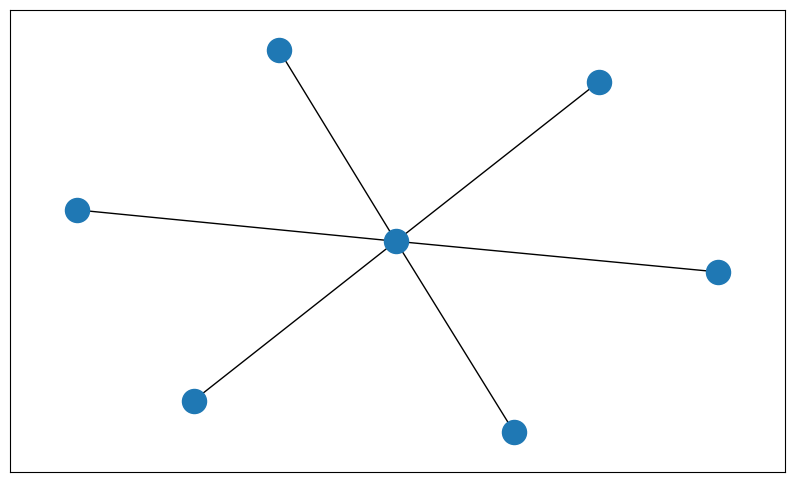

In [8]:
node_example = np.unique(edge_example.flatten())
plt.figure(figsize=(10, 6))
G = nx.Graph()
G.add_nodes_from(node_example)
G.add_edges_from(list(zip(edge_example[0], edge_example[1])))
nx.draw_networkx(G, with_labels=False)

## Grado del nodo: numero de aristas que unen un nodo en el grafico.

In [9]:
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
# Average node degree: 3.90

Average node degree: 3.90


Veamos la dsitribucion general del grado de los nodos

,count,mean,std,min,25%,50%,75%,max
0,2708.0,3.9,5.23,1.0,2.0,3.0,5.0,168.0


2708
10556


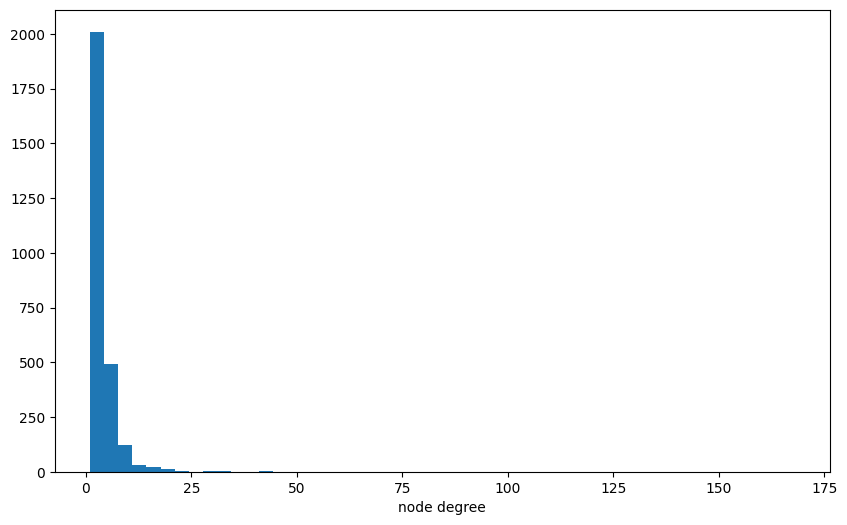

In [10]:
G = to_networkx(data, to_undirected=True)
degrees = [val for (node, val) in G.degree()]
display(pd.DataFrame(pd.Series(degrees).describe()).transpose().round(2))
print(len(degrees))
print(sum(degrees))
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=50)
plt.xlabel("node degree")
plt.show()

Es probable que los nodos con altos grados, sean importantes. (muy citado)

Veamos un grafico con los 10 principales nodos

threshold 0.011821204285186553


/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


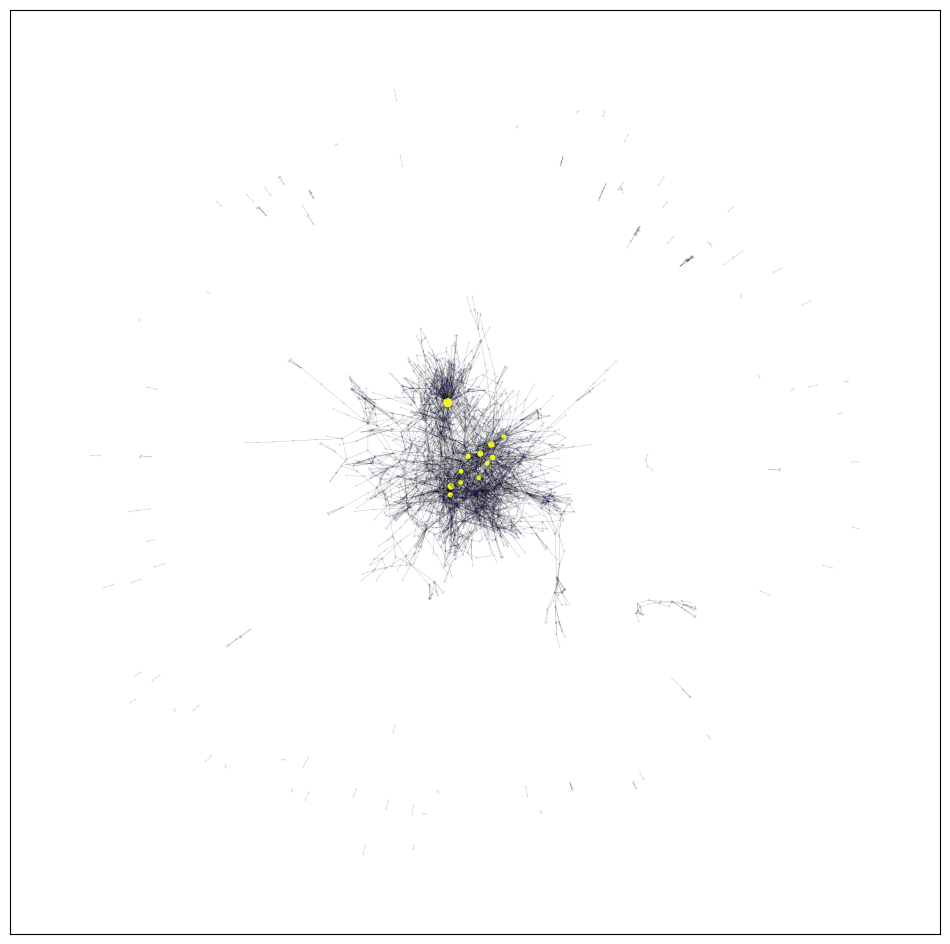

In [11]:
G = to_networkx(data, to_undirected=True)
pos = nx.spring_layout(G, seed=42)
cent = nx.degree_centrality(G)
node_size = list(map(lambda x: x * 500, cent.values()))
cent_array = np.array(list(cent.values()))
threshold = sorted(cent_array, reverse=True)[10]
print("threshold", threshold)
cent_bin = np.where(cent_array >= threshold, 1, 0.1)
plt.figure(figsize=(12, 12))
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size,
                               cmap=plt.cm.plasma,
                               node_color=cent_bin,
                               nodelist=list(cent.keys()),
                               alpha=cent_bin)
edges = nx.draw_networkx_edges(G, pos, width=0.25, alpha=0.3)
plt.show()

## Caracteristicas

Los articulos tienen 1433 caracteristicas.

Para cada una de las 1433 palabras, el número de características se expresa como 0 y 1 si la palabra está incluida o no en el documento.

In [12]:
print(f'Number of features: {data.num_node_features}')
# Number of edge features: 0

Number of features: 1433


In [13]:
print(len(data.x[0]))
data.x[0][:20]

1433


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1.])

Tenga en cuenta que ahora estamos viendo las características del nodo. Los bordes también pueden tener valores de características (características de borde), pero no están incluidos en el conjunto de datos de Cora.

In [14]:
print(f'Number of edge features: {data.num_edge_features}')
# Number of edge features: 0

Number of edge features: 0


## Clases

Los artículos del conjunto de datos de Cora están etiquetados con 7 etiquetas diferentes.

In [15]:
print(f'Number of classes: {dataset.num_classes}')
# Number of classes: 7

Number of classes: 7


Mostremos una parte de la clase y podemos ver que consta de números enteros entre 0 y 6. Cada número corresponde a un tema de la siguiente manera. Consulte aquí para obtener más detalles.

In [16]:
label_dict = {
    0: "Theory",
    1: "Reinforcement_Learning",
    2: "Genetic_Algorithms",
    3: "Neural_Networks",
    4: "Probabilistic_Methods",
    5: "Case_Based",
    6: "Rule_Learning"}
data.y[:10]

tensor([3, 4, 4, 0, 3, 2, 0, 3, 3, 2])

{3: 818, 4: 426, 0: 351, 2: 418, 1: 217, 5: 298, 6: 180}


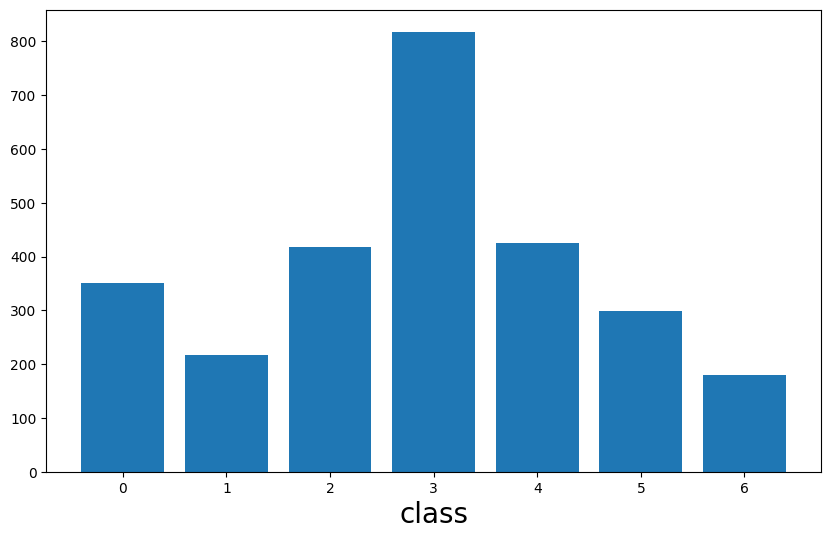

In [17]:
counter = collections.Counter(data.y.numpy())
counter = dict(counter)
print(counter)
count = [x[1] for x in sorted(counter.items())]
plt.figure(figsize=(10, 6))
plt.bar(range(7), count)
plt.xlabel("class", size=20)
plt.show()

A continuación, dibuje un diagrama de red para ver si las clases se distribuyen de forma coherente.

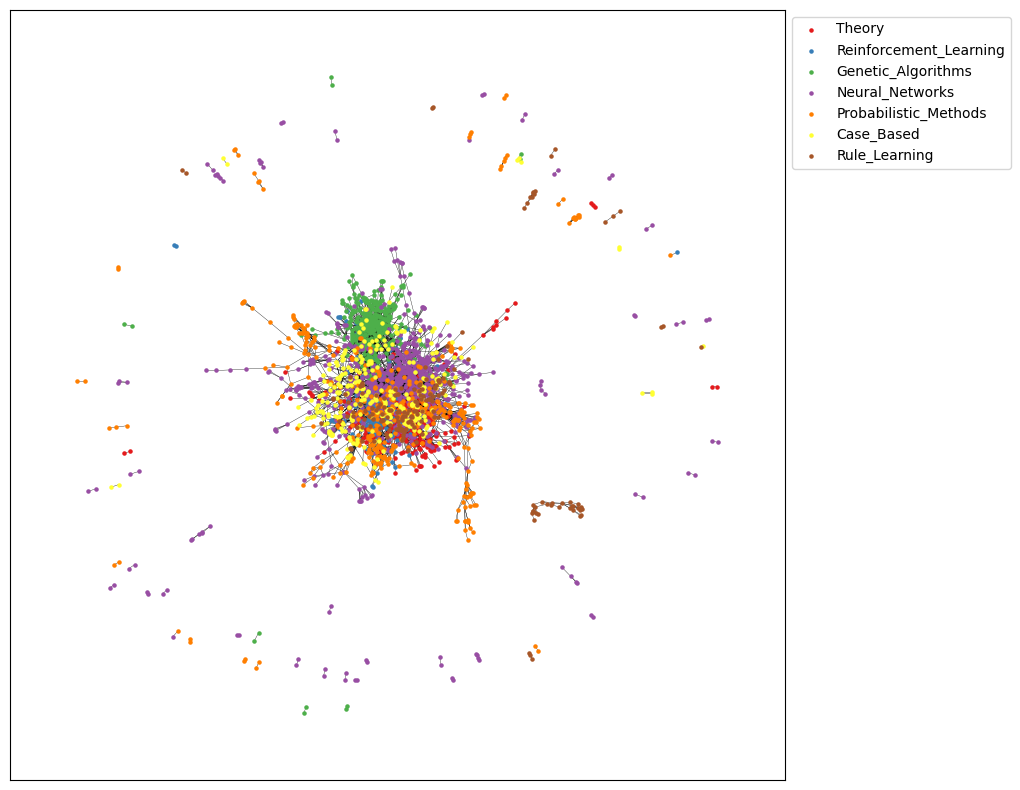

In [18]:
G = to_networkx(data, to_undirected=True)
node_color = []
nodelist = [[], [], [], [], [], [], []]
colorlist = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628']
labels = data.y
for n, i in enumerate(labels):
    node_color.append(colorlist[i])
    nodelist[i].append(n)
pos = nx.spring_layout(G, seed = 42)
plt.figure(figsize = (10, 10))
labellist = list(label_dict.values())
for num, i in enumerate(zip(nodelist, labellist)):
    n, l = i[0], i[1]
    nx.draw_networkx_nodes(G, pos, nodelist=n, node_size = 5, node_color = colorlist[num], label=l)
nx.draw_networkx_edges(G, pos, width = 0.25)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

Es un poco difícil de ver porque está trazado en dos dimensiones, pero parece como si las clases estuvieran un tanto agrupadas. Analizaremos este punto desde un ángulo diferente en la siguiente sección.

## homofilia
A menudo se conectan nodos con las mismas características.
Esta propiedad se llama homofilia. Para las siete clases que vimos anteriormente, veremos cuántos nodos de la misma clase están conectados por aristas y viceversa.

label: 0
1527 edges
{0: 1068, 3: 161, 5: 75, 4: 88, 1: 32, 6: 80, 2: 23}
label: 1
1029 edges
{0: 32, 1: 818, 2: 62, 6: 2, 5: 28, 3: 67, 4: 20}
label: 2
1826 edges
{3: 53, 2: 1654, 5: 30, 0: 23, 1: 62, 4: 2, 6: 2}
label: 3
2838 edges
{3: 2350, 4: 137, 0: 161, 5: 54, 1: 67, 2: 53, 6: 16}
label: 4
1592 edges
{4: 1320, 3: 137, 0: 88, 1: 20, 6: 6, 5: 19, 2: 2}
label: 5
1086 edges
{5: 834, 3: 54, 6: 46, 0: 75, 1: 28, 2: 30, 4: 19}
label: 6
658 edges
{6: 506, 0: 80, 3: 16, 5: 46, 4: 6, 1: 2, 2: 2}


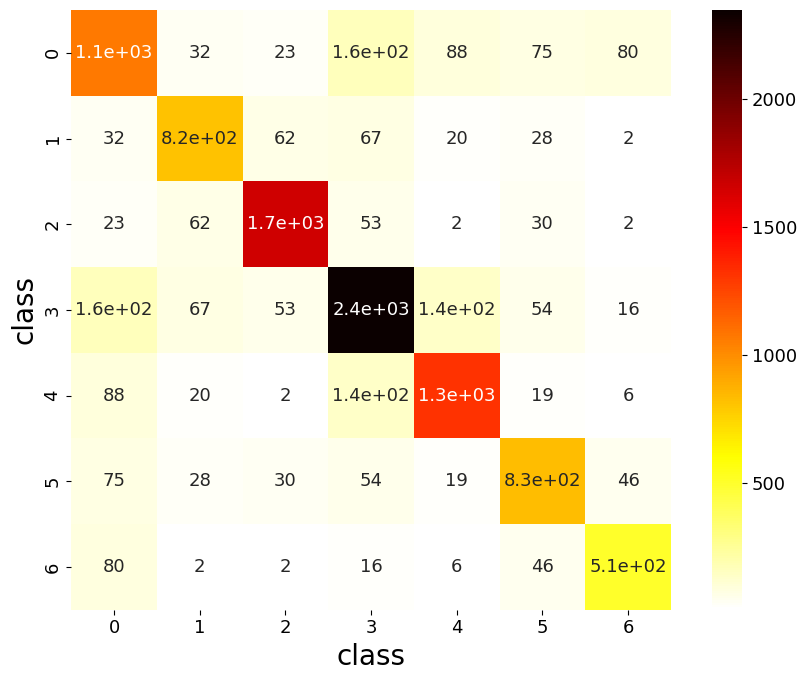

In [19]:
labels = data.y.numpy()
connected_labels_set = list(map(lambda x: labels[x], data.edge_index.numpy()))
connected_labels_set = np.array(connected_labels_set)
def add_missing_keys(counter, classes):
    for x in classes:
        if x not in counter.keys():
            counter[x] = 0
    return counter
label_connection_counts = []
for i in range(7):
    print(f"label: {i}")
    connected_labels = connected_labels_set[:, np.where(connected_labels_set[0] == i)[0]]
    print(connected_labels.shape[1], "edges")
    counter = collections.Counter(connected_labels[1])
    counter = dict(counter)
    print(counter)
    counter = add_missing_keys(counter, range(7))
    items = sorted(counter.items())
    items = [x[1] for x in items]
    label_connection_counts.append(items)
label_connection_counts = np.array(label_connection_counts)
plt.figure(figsize=(9, 7))
plt.rcParams["font.size"] = 13
hm = sns.heatmap(label_connection_counts, annot=True, cmap='hot_r', cbar=True, square=True)
plt.xlabel("class",size=20)
plt.ylabel("class",size=20)
plt.tight_layout()
plt.show()

Podemos ver que hay una gran cantidad de nodos que están conectados entre sí pertenecientes a la misma clase.

Al dividir la suma de los componentes diagonales de la matriz por la suma de todos los componentes, calculamos el porcentaje de aristas conectadas dentro de la misma clase.

In [20]:
label_connection_counts.diagonal().sum() / label_connection_counts.sum()
# 0.8099658961727927

0.8099658961727927

Parece que alrededor del 81% de los bordes están conectados dentro de la misma clase.

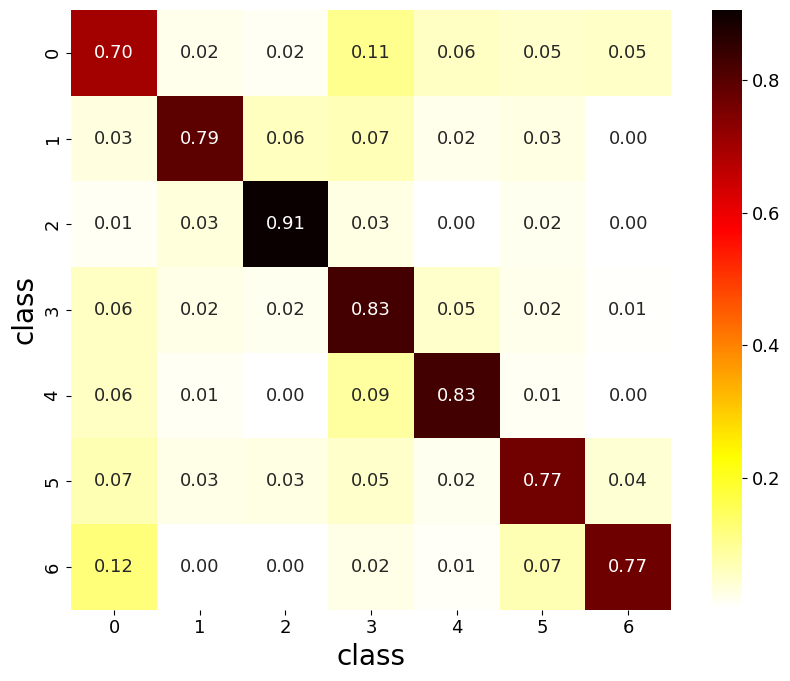

In [21]:
def scaling(array):
    return array / sum(array)
label_connection_counts_scaled = np.apply_along_axis(scaling, 1, label_connection_counts)
plt.figure(figsize=(9, 7))
plt.rcParams["font.size"] = 13
hm = sns.heatmap(
    label_connection_counts_scaled,
    annot=True,
    cmap='hot_r',
    fmt="1.2f",
    cbar=True,
    square=True)
plt.xlabel("class",size=20)
plt.ylabel("class",size=20)
plt.tight_layout()
plt.show()

¡Excelente! Podemos ver que para todas las clases, el mayor número de aristas están vinculadas a la misma clase. Esto también es más cierto para la Clase 2, donde aproximadamente el 91% de los bordes están unidos dentro de la misma clase. Por otro lado, la tendencia es relativamente débil en la Clase 0, con alrededor del 70% de los bordes dentro de la misma clase.

# Graph Neural Network

In [24]:
print(dataset)
print(dataset.data)
print("number of graphs:\t\t",len(dataset))
print("number of classes:\t\t",dataset.num_classes)
print("number of node features:\t",dataset.num_node_features)
print("number of edge features:\t",dataset.num_edge_features)

Cora()
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
number of graphs:		 1
number of classes:		 7
number of node features:	 1433
number of edge features:	 0


In [25]:
print("edge_index:\t\t",dataset.data.edge_index.shape)
print(dataset.data.edge_index)
print("\n")
print("train_mask:\t\t",dataset.data.train_mask.shape)
print(dataset.data.train_mask)
print("\n")
print("x:\t\t",dataset.data.x.shape)
print(dataset.data.x)
print("\n")
print("y:\t\t",dataset.data.y.shape)
print(dataset.data.y)

edge_index:		 torch.Size([2, 10556])
tensor([[ 633, 1862, 2582,  ...,  598, 1473, 2706],
        [   0,    0,    0,  ..., 2707, 2707, 2707]])


train_mask:		 torch.Size([2708])
tensor([ True,  True,  True,  ..., False, False, False])


x:		 torch.Size([2708, 1433])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


y:		 torch.Size([2708])
tensor([3, 4, 4,  ..., 3, 3, 3])


In [26]:
data = dataset[0]

##Net

Usaremos Graph Sage para prueba

In [29]:
import os.path as osp
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

In [27]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv = SAGEConv(dataset.num_features,
                             dataset.num_classes,
                             aggr="max") # max, mean, add ...)

    def forward(self):
        x = self.conv(data.x, data.edge_index)
        return F.log_softmax(x, dim=1)


In [30]:
device = torch.device('cuda' if torch.cuda.is_available() and use_cuda_if_available else 'cpu')
model, data = Net().to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [31]:
def train():
    model.train()
    optimizer.zero_grad()
    F.nll_loss(model()[data.train_mask], data.y[data.train_mask]).backward()
    optimizer.step()


def test():
    model.eval()
    logits, accs = model(), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

In [33]:
device

device(type='cpu')

In [32]:
best_val_acc = test_acc = 0
for epoch in range(1,100):
    train()
    _, val_acc, tmp_test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    log = 'Epoch: {:03d}, Val: {:.4f}, Test: {:.4f}'

    if epoch % 10 == 0:
        print(log.format(epoch, best_val_acc, test_acc))

Epoch: 010, Val: 0.7220, Test: 0.7250
Epoch: 020, Val: 0.7220, Test: 0.7250
Epoch: 030, Val: 0.7220, Test: 0.7250
Epoch: 040, Val: 0.7220, Test: 0.7250
Epoch: 050, Val: 0.7220, Test: 0.7250
Epoch: 060, Val: 0.7260, Test: 0.7040
Epoch: 070, Val: 0.7260, Test: 0.7040
Epoch: 080, Val: 0.7300, Test: 0.7160
Epoch: 090, Val: 0.7300, Test: 0.7160
